<a href="https://colab.research.google.com/github/janna-in-sf/DataSF-311-Cases/blob/main/DataSF_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataSF Project

Data from Data SF on 311 requests/cases to city of San Francisco. 

*    See: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6 
*   Started in January 2023
*   Janna Voss



## Imports

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time
from datetime import datetime

## Load Input File

### Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set variables
file_path = '/content/drive/MyDrive/colab_files/data/'
file_name = '311_Cases.csv'
absolute_file_name = file_path + file_name

# hardcoded column names for cols to keep from input CSV file
col_names = ['CaseID', 'Opened', 'Closed', 'Updated','Status', 'Status Notes',
             'Responsible Agency', 'Category', 'Request Type', 'Request Details',
             'Address', 'Street', 'Supervisor District', 'Neighborhood', 
             'Police District','Latitude', 'Longitude', 'Source']
col_types = {'Status': 'category', 'Supervisor District':'category', 
             'Police District':'category', 'Latitude': 'float32', 
             'Longitude': 'float32','Source':'category'}
col_index_name = 'CaseID'

### Read CSV

In [ ]:
# Load the file
print('Loading file: ', absolute_file_name,'\n')

rows_to_load = 1000000
csv_date_format = '%m/%d/%Y %I:%M:%S %p'

start = time.time()
print("Start Time =", datetime.now().strftime("%H:%M:%S"))

#df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=col_types, 
#                 index_col= col_index_name)
df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=col_types, 
                 index_col= col_index_name, nrows=rows_to_load)
# change type for dates
for date_col_name in ['Opened','Closed','Updated']:
  df[date_col_name] = pd.to_datetime(df[date_col_name],format=csv_date_format)

end = time.time()
print("End Time   =", datetime.now().strftime("%H:%M:%S"))
print('Elapsed time:',end - start, 'seconds')
print('\nLoaded file with (rows, cols) = ',df.shape,'\n')


Loading file:  /content/drive/MyDrive/colab_files/data/311_Cases.csv 

Start Time = 22:51:19
End Time   = 22:53:46
Elapsed time: 147.38300561904907 seconds

Loaded file with (rows, cols) =  (6045887, 17) 



In [ ]:
df.head()

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
6501676,2016-11-06 10:10:45,2016-11-07 09:11:12,2016-11-07 09:11:12,Closed,Case Resolved - 10-98,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"2953 HARRISON ST, SAN FRANCISCO, CA, 94110",HARRISON ST,9,Mission,MISSION,37.750233,-122.411804,Mobile/Open311
6484030,2016-11-01 11:26:26,2016-11-01 16:59:33,2016-11-01 16:59:33,Closed,Case Resolved - Pickup completed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of ISADORA DUNCAN LN and TAYLOR ST,ISADORA DUNCAN LN,3,Lower Nob Hill,CENTRAL,37.787567,-122.411644,Phone
6505388,2016-11-07 11:08:09,2016-11-12 16:40:17,2016-11-12 16:40:17,Closed,Case Resolved - entire area is trashed out nee...,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,Intersection of ARELIOUS WALKER DR and REVERE AVE,ARELIOUS WALKER DR,10,Hunters Point,BAYVIEW,37.725494,-122.378494,Mobile/Open311
6504738,2016-11-07 09:41:28,2016-11-07 11:11:06,2016-11-07 11:11:06,Closed,Case Resolved - If the bridge is closed DPW ca...,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,"1366 VERMONT ST, SAN FRANCISCO, CA, 94110",VERMONT ST,10,Potrero Hill,MISSION,37.752312,-122.403488,Mobile/Open311
6507086,2016-11-07 15:40:03,2016-11-08 10:10:08,2016-11-08 10:10:08,Closed,Case Resolved - meter shop has closed this req...,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,"2664 MISSION ST, SAN FRANCISCO, CA, 94110",MISSION ST,9,Mission,MISSION,37.754307,-122.418839,Phone


In [ ]:
df.shape

(6045887, 17)

### Sort by index (CaseId)

In [ ]:
# if values in Index are NOT monotonically increasing, sort index
print('Index is monotnoic:',df.index.is_monotonic)
print(df[['Opened','Closed','Updated']].head(3))

if (not df.index.is_monotonic):
  df.sort_index(inplace=True)
  print('\n*** After sorting index, index is monotnoic:',df.index.is_monotonic)
  print(df[['Opened','Closed','Updated']].head(3))

Index is monotnoic: False
                     Opened              Closed             Updated
CaseID                                                             
6501676 2016-11-06 10:10:45 2016-11-07 09:11:12 2016-11-07 09:11:12
6484030 2016-11-01 11:26:26 2016-11-01 16:59:33 2016-11-01 16:59:33
6505388 2016-11-07 11:08:09 2016-11-12 16:40:17 2016-11-12 16:40:17

*** After sorting index, index is monotnoic: True
                    Opened              Closed             Updated
CaseID                                                            
240215 2008-07-01 00:13:13 2008-07-02 16:05:13 2008-07-02 16:05:13
240216 2008-07-01 00:26:34 2008-07-01 06:10:23 2008-07-01 06:10:23
240220 2008-07-01 01:56:58 2008-07-01 06:10:23 2008-07-01 06:10:23


## Exploratory Data Analysis

### Address Any Nulls

In [ ]:
# Check for nulls
assert df.isna().sum().sum()==0, 'nulls found, may need to address nulls'

AssertionError: ignored

In [ ]:
df.Status.value_counts()

Closed    5941683
Open       104204
Name: Status, dtype: int64

In [ ]:
# Drop row(s) containing null in a column that has nulls in 5% (or less) of total nbr of row
# Note: Don't drop rows with null in 'Closed' - doing so will remove all open open cases

# out of 6M rows, dropped 103,904

if df.isna().sum().sum() > 0:
  threshold = df.shape[0] * 0.05
  max_rows_to_drop = 0

  cols_below_threshold = df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold)]

  if 'Closed' in cols_below_threshold or 'Updated' in cols_below_threshold:
    cols_below_threshold = cols_below_threshold.drop(['Closed','Updated'])

  if len(cols_below_threshold) > 0 :
    for col in cols_below_threshold:
      max_rows_to_drop += df[col].isna().sum()

    print('Threshold:', threshold)
    print('*** Number of na, by column')
    print(df.isna().sum(),'\n')
    print('Nbr of columns below threshold (excluding "Closed"):',len(cols_below_threshold))
    print('Names of columns below threshold:', cols_below_threshold)
    print('(Will drop no more than', max_rows_to_drop,'rows)')

    df2 = df.copy()
    df.dropna(subset=cols_below_threshold, inplace=True)
    print('\n*** Number of rows dropped due to nulls:', df2.shape[0]-df.shape[0])

    # validate 
    assert df.shape[1] == df2.shape[1], 'ERROR: Logic to drop rows for nulls inadvertently dropped columns!'
    assert df2.shape[0]-df.shape[0] <= max_rows_to_drop, 'Dropped more rows than expected'
    for col in cols_below_threshold:
      assert df[col].isna().sum() == 0, f'Did not remove rows with nulls in col {col}'
  
    del df2, cols_below_threshold, max_rows_to_drop

Threshold: 302294.35000000003
*** Number of na, by column
Opened                      0
Closed                 104205
Updated                     1
Status                      0
Status Notes            13567
Responsible Agency          0
Category                    0
Request Type                0
Request Details         90343
Address                    15
Street                 351404
Supervisor District    351384
Neighborhood           355646
Police District        358159
Latitude                    0
Longitude                   0
Source                      0
dtype: int64 

Nbr of columns below threshold (excluding "Closed"): 4
Names of columns below threshold: Index(['Updated', 'Status Notes', 'Request Details', 'Address'], dtype='object')
(Will drop no more than 103926 rows)

*** Number of rows dropped due to nulls: 103904


### Address Duplicate Rows

In [ ]:
# Check for duplicate rows
assert df.duplicated().sum() == 0, f'Found {df.duplicated().sum()} duplicated rows'

AssertionError: ignored

In [ ]:
# Drop the duplicated rows, keeping the first istance
if df.duplicated().sum() > 0:
  before_dropping_dups = df.shape[0]

  df_dups = df[df.duplicated(keep=False)]
  print('Number of duplicated rows:', len(df_dups))

  df.drop_duplicates(keep='first', inplace=True)
  print('Number of rows dropped due to dups',before_dropping_dups - df.shape[0])
  del df_dups

Number of duplicated rows: 1450
Number of rows dropped due to dups 763


### Summary Stats

In [ ]:
df.head()

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
240215,2008-07-01 00:13:13,2008-07-02 16:05:13,2008-07-02 16:05:13,Closed,- See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"408 UNION ST, SAN FRANCISCO, CA, 94133",UNION ST,3,Telegraph Hill,CENTRAL,37.800987,-122.406204,Phone
240216,2008-07-01 00:26:34,2008-07-01 06:10:23,2008-07-01 06:10:23,Closed,- See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of 18TH AVE and JUDAH ST,18TH AVE,7,Inner Sunset,TARAVAL,37.761745,-122.475922,Phone
240220,2008-07-01 01:56:58,2008-07-01 06:10:23,2008-07-01 06:10:23,Closed,- See Notes tab for more details,DPW Ops Queue,Tree Maintenance,Trees - Damaged_Tree,Hanging_limb,Intersection of 2ND AVE and IRVING ST,2ND AVE,5,Inner Sunset,PARK,37.764366,-122.458817,Phone
240221,2008-07-01 02:07:11,2008-07-08 10:03:41,2008-07-08 10:03:41,Closed,- DPT Abandoned Vehicles - Gone on Arrival #391,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicle - Car4door,DARK BLUE - FORD - CROWN VICTORIA - 3WBG858,"1271 EDDY ST, SAN FRANCISCO, CA, 94115",EDDY ST,5,Western Addition,NORTHERN,37.781799,-122.428535,Phone
240222,2008-07-01 03:03:08,2008-07-01 06:10:23,2008-07-01 06:10:23,Closed,- See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of BROOK ST and MISSION ST,BROOK ST,9,Bernal Heights,INGLESIDE,37.740643,-122.423088,Phone


In [ ]:
df.tail()

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
16471008,2023-02-24 14:57:22,2023-02-25 17:25:33,2023-02-25 17:25:33,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"714 PACIFIC AVE, SAN FRANCISCO, CA, 94133",PACIFIC AVE,3,Chinatown,CENTRAL,37.796913,-122.407005,Mobile/Open311
16471221,2023-02-24 15:26:00,2023-02-25 19:26:00,2023-02-25 19:26:00,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"608 19TH AVE, SAN FRANCISCO, CA, 94121",19TH AVE,1,Inner Richmond,RICHMOND,37.776474,-122.477966,Mobile/Open311
16471225,2023-02-24 15:26:00,2023-02-25 09:08:49,2023-02-25 09:08:49,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,Intersection of 39TH AVE and LAWTON ST,39TH AVE,4,Outer Sunset,TARAVAL,37.757019,-122.498161,Mobile/Open311
16471248,2023-02-24 15:28:00,2023-02-25 09:08:30,2023-02-25 09:08:30,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,Intersection of 34TH AVE and LAWTON ST,34TH AVE,4,Outer Sunset,TARAVAL,37.757259,-122.492813,Mobile/Open311
16471260,2023-02-24 15:30:00,2023-02-25 14:38:03,2023-02-25 14:38:03,Closed,Removed - Case Resolved - TLCBD clean team res...,Tenderloin CBD Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,Intersection of LEAVENWORTH ST and ELLIS ST,LEAVENWORTH ST,5,Tenderloin,TENDERLOIN,37.784657,-122.414429,Phone


In [ ]:
df.sample(n=3)

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
3360746,2014-02-12 10:14:14,2014-02-12 14:52:47,2014-02-12 14:52:47,Closed,Case Transferred - New SR#3361851,311 Supervisor Queue,Rec and Park Requests,Park - Park_Patrol,Other,"95 BLUXOME ST, SAN FRANCISCO, CA, 94107",BLUXOME ST,6,South of Market,SOUTHERN,37.775764,-122.397835,Mobile/Open311
3096508,2013-11-23 11:28:53,2013-12-03 14:05:55,2013-12-03 14:05:55,Closed,Case Completed - resolved:,DPW Ops Queue,Tree Maintenance,Trees - Landscaping,Other,"706 42ND AVE, SAN FRANCISCO, CA, 94121",42ND AVE,1,Outer Richmond,RICHMOND,37.775478,-122.502411,Mobile/Open311
3396545,2014-02-24 09:41:03,2014-02-24 12:49:48,2014-02-24 12:49:48,Closed,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"3219 17TH ST, SAN FRANCISCO, CA, 94110",17TH ST,9,Mission,MISSION,37.763489,-122.417854,Mobile/Open311


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980615 entries, 240215 to 16471260
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Opened               980615 non-null  datetime64[ns]
 1   Closed               977833 non-null  datetime64[ns]
 2   Updated              980615 non-null  datetime64[ns]
 3   Status               980615 non-null  category      
 4   Status Notes         980615 non-null  object        
 5   Responsible Agency   980615 non-null  object        
 6   Category             980615 non-null  object        
 7   Request Type         980615 non-null  object        
 8   Request Details      980615 non-null  object        
 9   Address              980615 non-null  object        
 10  Street               865859 non-null  object        
 11  Supervisor District  865860 non-null  category      
 12  Neighborhood         864544 non-null  object        
 13  Police 

In [ ]:
# nbr unique for each col
print('Nbr unique values per column, out of total of',df.shape[0],'rows\n')
print(df.nunique(dropna=False))

Nbr unique values per column, out of total of 980615 rows

Opened                 969226
Closed                 789011
Updated                791639
Status                      2
Status Notes           265128
Responsible Agency        324
Category                  102
Request Type              879
Request Details         64517
Address                131811
Street                   2842
Supervisor District        13
Neighborhood              118
Police District            11
Latitude                26276
Longitude               17779
Source                      8
dtype: int64


In [ ]:
df.Status.value_counts()

Closed    5851846
Open        89374
Name: Status, dtype: int64

### Consider Catagorical Features

In [ ]:
# These are numbers, but not measures.
# Does the number indicate a supervisor or (more likely) an area of the city?
# How does this district compare to 'Police District' or 'Neighborhood'?
# There are 13 Supervisor Districts and 11 Police Districts, (118 Neighborhoods) -
#      are the line designating these districts the same?
df['Supervisor District'].value_counts()


9     933109
5     691586
3     634106
6     632413
8     569020
10    542803
1     398996
2     339460
11    337360
7     263187
4     253879
0       4181
Name: Supervisor District, dtype: int64

In [ ]:
df['Police District'].value_counts()
# ALLCAPS

MISSION       1038886
NORTHERN       685899
INGLESIDE      598767
CENTRAL        559822
SOUTHERN       531115
TARAVAL        516856
BAYVIEW        514882
RICHMOND       460453
PARK           452292
TENDERLOIN     234437
NO                  1
Name: Police District, dtype: int64

In [ ]:
df.Source.value_counts()

Mobile/Open311       2625076
Phone                2263422
Web                   847498
Integrated Agency     157753
Twitter                40413
Other Department        5988
Email                   1060
Mail                      10
Name: Source, dtype: int64

In [ ]:
#print(df['Status Notes'].sample(n=8))

CaseID
728000                        See Notes tab for more details
6392716    Case Resolved - no cross street or address ......
666209                        See Notes tab for more details
6247453    Case Resolved - Duplicate Complaint. - Duplica...
6461082    Case is a Duplicate - per DPW this is a duplicate
6451814    Case Resolved - 201643091 has been filed with ...
605252       Case Resolved - RESET PRIMARY METER OK; 2/23/10
6451345                                     Case Transferred
Name: Status Notes, dtype: object


In [ ]:
# Request type: most common 'General Cleaning' & 'Bulky Items'
df['Request Type'].value_counts().nlargest(n=10)


Bulky Items                                         887923
General Cleaning                                    810808
Encampment Reports                                  302959
request_for_service                                 264105
Human or Animal Waste                               256911
City_garbage_can_overflowing                        121985
Graffiti on Other_enter_additional_details_below    114356
Graffiti on Building_commercial                     110040
Other_Illegal_Parking                               104826
complaint                                            90636
Name: Request Type, dtype: int64

In [ ]:
#earliest requests that are still open
df[df['Status']=='Open'].nsmallest(n=5, columns='Opened')

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
399256,2009-03-27 09:41:46,NaT,2009-04-03 13:37:48,Open,open,PUC Sewer Ops,General Request - PUC,customer_callback,sewer - customer_callback,Intersection of CESAR CHAVEZ ST and HARRISON ST,CESAR CHAVEZ ST,9,Bernal Heights,MISSION,37.748299,-122.411484,Phone
406169,2009-04-06 13:06:34,NaT,2009-04-07 09:29:23,Open,open,DPT SignShop,Sign Repair,Sign - Missing,Street_Name - Missing; support - OK,Intersection of 1ST ST and TEHAMA ST,1ST ST,6,South of Market,SOUTHERN,37.788094,-122.395477,Phone
406801,2009-04-07 10:54:19,NaT,2009-04-08 16:56:43,Open,open,DPT SignShop,General Request - MTA,request_for_service,parking_traffic_other - request_for_service,"320 UPPER TER, SAN FRANCISCO, CA, 94117",UPPER TER,8,Buena Vista,PARK,37.762341,-122.446167,Phone
414230,2009-04-18 20:22:22,NaT,2009-04-18 20:25:46,Open,open,DPW - Bureau of Urban Forestry - G,General Request - PUBLIC WORKS,customer_callback,buf - customer_callback,"433 DOUGLASS ST, SAN FRANCISCO, CA, 94114",DOUGLASS ST,8,Eureka Valley,MISSION,37.756699,-122.438812,Phone
419502,2009-04-26 21:06:39,NaT,2009-04-26 21:11:48,Open,open,DPW - Bureau of Street Use and Mapping - G,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone


### Drop rows where 'Status Notes' contains 'Case is a Duplicate'

In [ ]:
# first take a look
df_quick = df[df['Status Notes'].notnull() & df['Status Notes'].str.contains('Case is a Duplicate',case=False)]
df_quick.head()

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
240403,2008-07-01 10:00:27,2008-07-01 16:09:07,2008-07-01 16:09:07,Closed,- Case is a Duplicate refer to sr 240401,DPT Construction Zone Permits Queue,Construction Zone Permits,Construction Zone Tow-away Permits for Water D...,Water Department,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone
240941,2008-07-01 19:37:50,2008-07-15 08:30:59,2008-07-15 08:30:59,Closed,- Case is a Duplicate,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicle - Other,Tan - Jamboree - RV - NA,Intersection of 23RD ST and FLORIDA ST,23RD ST,9,Mission,MISSION,37.754341,-122.410217,Phone
241091,2008-07-02 09:14:54,2008-12-27 16:43:27,2008-12-27 16:43:27,Closed,Case is a Duplicate - please see sr# 234644 WO...,Housing Authority SR Queue,SFHA Requests,Tile Work,Tile Work - Routine,"3 WATCHMAN WAY, SAN FRANCISCO, CA, 94107",WATCHMAN WAY,10,Potrero Hill,BAYVIEW,37.755699,-122.396004,Phone
241146,2008-07-02 10:22:08,2008-12-27 18:55:57,2008-12-27 18:55:57,Closed,Case is a Duplicate - enetered in existing WO#...,Housing Authority SR Queue,SFHA Requests,Electrical,Electrical - Routine,"330 CLEMENTINA ST, Apt 815, SAN FRANCISCO, CA,...",CLEMENTINA ST,6,South of Market,SOUTHERN,37.782200,-122.403000,Phone
241171,2008-07-02 10:52:28,2008-12-27 18:57:24,2008-12-27 18:57:24,Closed,Case is a Duplicate - see SR# 243462 WO# 980559,Housing Authority SR Queue,SFHA Requests,Steam Fitter,Steam Fitter - Emergency,BUILDING 1054 - 1068 CONNECTICUT,BUILDING 1054 - 1068 CONNECTICUT,10,Potrero Hill,BAYVIEW,37.753132,-122.397499,Phone


In [ ]:
df.loc[[240401,240403]]

,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
240401,2008-07-01 09:57:25,2008-07-01 16:00:50,2008-07-01 16:00:50,Closed,- Case Resolved sc enter,DPT Construction Zone Permits Queue,Construction Zone Permits,Construction Zone Tow-away Permits for Water D...,Water Department,Not associated with a specific address,NaN,NaN,NaN,NaN,0.0,0.0,Phone
240403,2008-07-01 10:00:27,2008-07-01 16:09:07,2008-07-01 16:09:07,Closed,- Case is a Duplicate refer to sr 240401,DPT Construction Zone Permits Queue,Construction Zone Permits,Construction Zone Tow-away Permits for Water D...,Water Department,Not associated with a specific address,NaN,NaN,NaN,NaN,0.0,0.0,Phone


In [ ]:
# df with 'Status Notes' contains 'Case is a Duplicate'
df_quick = df[df['Status Notes'].notnull() & df['Status Notes'].str.contains('Case is a Duplicate',case=False)]
if len(df_quick) > 0:
  print('Found', df_quick.shape[0],'rows with "Status Notes" containing "Case is a Duplicate"\n')
  before_drop = df.shape[0]

  # drop those rows
  df = df.drop(df_quick.index)

  #df.info()
  print('Dropped', before_drop - df_quick.shape[0], 'rows containing "Case is a Duplicate"')
  assert df.shape[0] == before_drop - df_quick.shape[0], 'Dropped unexpected number of rows'
  del df_quick

Found 0 rows with "Status Notes" containing "Case is a Duplicate"

Dropped 958906 rows containing "Case is a Duplicate"


###Feature Engineering

In [ ]:
# Create dataframe for open 311 cases
df_open = df[df['Status']=='Open'].copy()
df_open = df_open.drop(columns=['Closed','Status'])
df_open.shape

(714, 15)

In [ ]:
# Create dataframe for closed 311 cases
df_closed = df[df['Status']=='Closed'].copy()
df_closed = df_closed.drop(columns='Status')
df_closed.shape

(490280, 16)

In [ ]:
# new cols...
#  calculate how long open cases have been open (days_open)
#  calculate processing_days for closed cases

df_open['days_open'] = (datetime.now() - df_open['Opened']).astype("timedelta64[D]").astype('int')
df_closed['opened_month_year'] = df_closed['Opened'].dt.to_period('M')
df_closed['opened_year'] = df_closed['Opened'].dt.to_period('Y')
df_closed['processing_days'] = (df_closed['Closed'] - df_closed['Opened']).astype("timedelta64[D]").astype('int')

# processing_days is < 1 if Closed date is earlier than Opened date, set to 1 (1 day to close)
df_closed.loc[df_closed['processing_days'] < 1, 'processing_days'] = 1

In [ ]:
df_closed.opened_month_year.value_counts()
# Why were so many cases opened in 20/2016? (And this shows only the cases that were closed)

2016-08    33637
2016-09    31436
2016-06    30550
2016-10    30520
2016-07    28142
           ...  
2015-10        1
2016-01        1
2017-04        1
2017-06        1
2015-12        1
Freq: M, Name: opened_month_year, Length: 129, dtype: int64

In [ ]:
#df_2016 = df_closed[df_closed.opened_month_year between 2015-12 and 201701]]


In [ ]:
df_closed.head()

,Opened,Closed,Updated,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,opened_month_year,processing_days,opened_year
CaseID,,,,,,,,,,,,,,,,,,,
240215,2008-07-01 00:13:13,2008-07-02 16:05:13,2008-07-02 16:05:13,- See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"408 UNION ST, SAN FRANCISCO, CA, 94133",UNION ST,3,Telegraph Hill,CENTRAL,37.800987,-122.406204,Phone,2008-07,1,2008
240216,2008-07-01 00:26:34,2008-07-01 06:10:23,2008-07-01 06:10:23,- See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of 18TH AVE and JUDAH ST,18TH AVE,7,Inner Sunset,TARAVAL,37.761745,-122.475922,Phone,2008-07,1,2008
240220,2008-07-01 01:56:58,2008-07-01 06:10:23,2008-07-01 06:10:23,- See Notes tab for more details,DPW Ops Queue,Tree Maintenance,Trees - Damaged_Tree,Hanging_limb,Intersection of 2ND AVE and IRVING ST,2ND AVE,5,Inner Sunset,PARK,37.764366,-122.458817,Phone,2008-07,1,2008
240221,2008-07-01 02:07:11,2008-07-08 10:03:41,2008-07-08 10:03:41,- DPT Abandoned Vehicles - Gone on Arrival #391,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicle - Car4door,DARK BLUE - FORD - CROWN VICTORIA - 3WBG858,"1271 EDDY ST, SAN FRANCISCO, CA, 94115",EDDY ST,5,Western Addition,NORTHERN,37.781799,-122.428535,Phone,2008-07,7,2008
240222,2008-07-01 03:03:08,2008-07-01 06:10:23,2008-07-01 06:10:23,- See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of BROOK ST and MISSION ST,BROOK ST,9,Bernal Heights,INGLESIDE,37.740643,-122.423088,Phone,2008-07,1,2008


In [ ]:
df_closed.processing_days.value_counts()

1      24107
2       2525
4       2260
3       2153
6       1946
       ...  
627        1
592        1
126        1
248        1
173        1
Name: processing_days, Length: 156, dtype: int64

In [ ]:
df_closed.opened_month_year.value_counts()

2016-10    30519
2016-09     9647
2016-11     7777
2014-10      161
2014-11      142
           ...  
2017-10        1
2014-03        1
2017-05        1
2017-03        1
2015-02        1
Freq: M, Name: opened_month_year, Length: 70, dtype: int64

In [ ]:
df_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490280 entries, 240215 to 16206027
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Opened               490280 non-null  datetime64[ns]
 1   Closed               490280 non-null  datetime64[ns]
 2   Updated              490280 non-null  datetime64[ns]
 3   Status Notes         489755 non-null  object        
 4   Responsible Agency   490280 non-null  object        
 5   Category             490280 non-null  object        
 6   Request Type         490280 non-null  object        
 7   Request Details      484491 non-null  object        
 8   Address              490279 non-null  object        
 9   Street               419086 non-null  object        
 10  Supervisor District  419087 non-null  category      
 11  Neighborhood         418396 non-null  object        
 12  Police District      418307 non-null  category      
 13  Latitud

In [ ]:
print('rows where "Closed" date is earlier than "Opened" date...')
df_closed[ df_closed['Closed'] < df_closed['Opened'] ]

# often the date is same, but closed time is before opened time
# resulting in a negative value for processing_time

rows where "Closed" date is earlier than "Opened" date...


,Opened,Closed,Updated,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,processing_days
CaseID,,,,,,,,,,,,,,,,,
4060014,2014-09-29 16:51:35,2014-09-29 07:07:59,2014-09-29 07:07:59,Case Completed - resolved:,DPW Ops Queue,DPW Volunteer Programs,Graffiti_Watch,Graffiti_Watch,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,1
4092297,2014-10-09 16:25:06,2014-10-09 06:55:00,2014-10-09 06:55:00,Case Completed - resolved: 10/98,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,1
4132577,2014-10-21 16:37:47,2014-10-21 05:01:00,2014-10-21 05:01:00,Case Completed - resolved:,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_structure,Sidewalk_structure - Offensive,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,1
4159701,2014-10-30 10:22:55,2014-10-30 04:02:12,2014-10-30 04:02:12,Case Completed - resolved: 10-98,DPW Ops Queue,General Request - PUBLIC WORKS,request_for_service,bses - request_for_service,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,1
4161676,2014-10-30 16:42:06,2014-10-30 12:54:41,2014-10-30 12:54:41,Case Completed - resolved: 10-98,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,1
4169493,2014-11-02 14:51:19,2014-11-02 03:52:00,2014-11-02 03:52:00,Case Completed - resolved:,DPW Ops Queue,Graffiti,Graffiti on Pole,Pole - Offensive,"680 HAYES ST, SAN FRANCISCO, CA, 94102",HAYES ST,5,Hayes Valley,NORTHERN,37.776436,-122.427583,Twitter,1
4220604,2014-11-18 11:45:12,2014-11-18 01:20:00,2014-11-18 01:20:00,Case Completed - resolved:,DPW Ops Queue,DPW Volunteer Programs,Community_Clean_Team,Community_Clean_Team,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,1
4242918,2014-11-25 12:00:22,2014-11-25 09:33:00,2014-11-25 09:33:00,Case Completed - resolved: 10/98,DPW Ops Queue,Street and Sidewalk Cleaning,Medical Waste,Needles,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,1
4257258,2014-12-01 09:52:21,2014-12-01 07:02:58,2014-12-01 07:02:58,Case Completed - resolved: 1098,DPW Ops Queue,General Request - PUBLIC WORKS,request_for_service,bses - request_for_service,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,1


### Descriptive Analytics

In [ ]:
df_open.describe(datetime_is_numeric=True)

,Opened,Updated,Latitude,Longitude,days_open
count,714,714,714.000000,714.000000,714.000000
mean,2017-01-05 23:35:37.376750848,2017-01-30 09:16:14.785714432,32.474918,-105.280949,2237.595238
min,2009-03-20 10:03:33,2009-03-25 07:31:20,0.000000,-122.512859,63.000000
25%,2016-06-03 21:04:33.500000,2016-06-06 14:22:44.500000,37.730998,-122.438541,398.250000
50%,2016-08-14 01:48:13,2016-08-15 03:02:43.500000,37.762400,-122.418594,2382.500000
75%,2022-01-19 05:22:30,2022-08-05 06:10:04.500000,37.781174,-122.398111,2453.750000
max,2022-12-20 16:02:00,2022-12-24 06:25:42,37.808547,0.000000,5086.000000
std,NaN,NaN,13.115017,42.517725,1554.973727


In [ ]:
df_closed.describe(datetime_is_numeric=True)
# note that the max is WAY higher than 75 percentile... outlier(s) 

,Opened,Closed,Updated,Latitude,Longitude,processing_days
count,490280,490280,490280,490280.000000,490280.000000,490280.000000
mean,2012-03-09 22:49:26.067646976,2012-03-28 00:52:38.380499200,2012-03-28 00:52:38.384376320,32.254491,-104.574718,17.894446
min,2008-07-01 00:13:13,2008-07-01 06:10:23,2008-07-01 06:10:23,0.000000,-122.514437,1.000000
25%,2009-06-17 10:44:52.500000,2009-07-13 11:16:21.249999872,2009-07-13 11:16:21.249999872,37.726990,-122.437447,1.000000
50%,2010-03-30 10:20:12.500000,2010-04-20 16:18:17.500000,2010-04-20 16:18:17.500000,37.759568,-122.418428,3.000000
75%,2016-07-15 13:58:12.249999872,2016-07-24 10:10:47.249999872,2016-07-24 10:10:47.249999872,37.777940,-122.402100,11.000000
max,2022-12-20 16:05:00,2022-12-21 10:30:11,2022-12-21 10:30:11,37.881603,0.000000,2897.000000
std,NaN,NaN,NaN,13.327581,43.210300,47.599264


In [ ]:
print(df_closed.nunique(dropna=False))

Opened                 487373
Closed                 344351
Updated                344351
Status Notes           114487
Responsible Agency        291
Category                  100
Request Type              699
Request Details         29086
Address                 90113
Street                   2585
Supervisor District        13
Neighborhood              118
Police District            11
Latitude               120087
Longitude              109012
Source                      8
opened_month_year         129
processing_days           781
dtype: int64


##Exploratory Visualization

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

### Visualize source

In [ ]:
df.Source.value_counts()

Mobile/Open311       24776
Phone                16663
Web                   7072
Integrated Agency     1160
Twitter                244
Other Department        85
Name: Source, dtype: int64

In [ ]:
df.Source.value_counts().pivot().plot(kind='bar')
#plot.(df.Source.value_counts().plot(kind='bar')
plt.show()

AttributeError: ignored

### Histograms for time open

In [ ]:
print('Quick stats on "days open", use to set range on histogram')
print(df_open.days_open.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "days open", use to set range on histogram
min         63.000000
max       5086.000000
mean      2237.595238
median    2382.500000
mode       199.000000
Name: days_open, dtype: float64


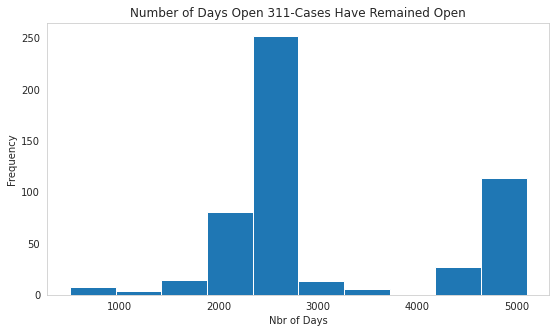

In [ ]:
# hist to visaulize nbr of days open cases have remained open

# NOTE 
# Currently need to manually change the plot range to account 
# for range cases have been open, esp. in regard to the *mean*

sns.set_style("whitegrid", {'axes.grid' : False})
plt.title('Number of Days Open 311-Cases Have Remained Open')
plt.xlabel('Nbr of Days')
df_open['days_open'].plot(kind='hist', range=[500,5100], figsize=(9,5))
plt.show()

### Histograms processing time 

In [ ]:
print('Quick stats on "processing days", use to set range on histogram')
print(df_closed.processing_days.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "processing days", use to set range on histogram
min          1.000000
max       2897.000000
mean        17.894446
median       3.000000
mode         1.000000
Name: processing_days, dtype: float64


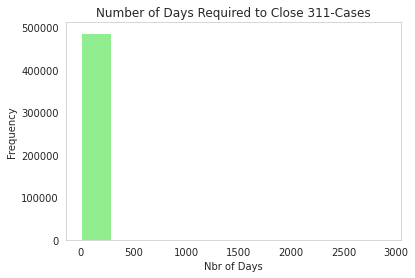

In [ ]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases')
plt.xlabel('Nbr of Days')
df_closed['processing_days'].plot(kind='hist', color='lightgreen')
plt.show()
# frequency scale is too broad to show any detail

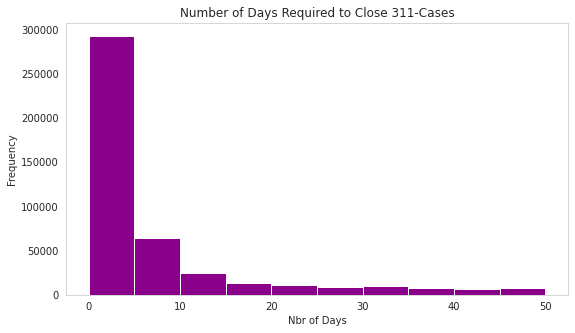

In [ ]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases')
plt.xlabel('Nbr of Days')
df_closed['processing_days'].plot(kind='hist', range=[0,50], color='DarkMagenta', figsize=(9,5))
plt.show()

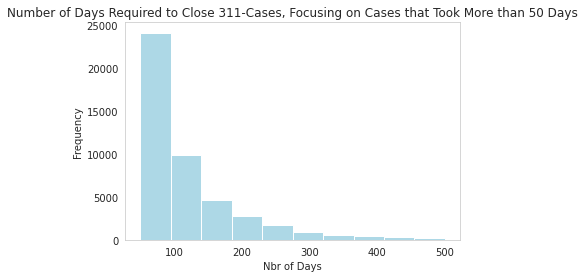

In [ ]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases, Focusing on Cases that Took More than 50 Days')
plt.xlabel('Nbr of Days')
#df_closed['processing_days'].plot(kind='hist', range=[100,900], color='LightBlue')
df_closed['processing_days'].plot(kind='hist', range=[50,500], color='LightBlue')
plt.show()

In [ ]:
df_proc_less_100 = df_closed[df_closed['processing_days']<100]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(469619, 18)
(20661, 18)


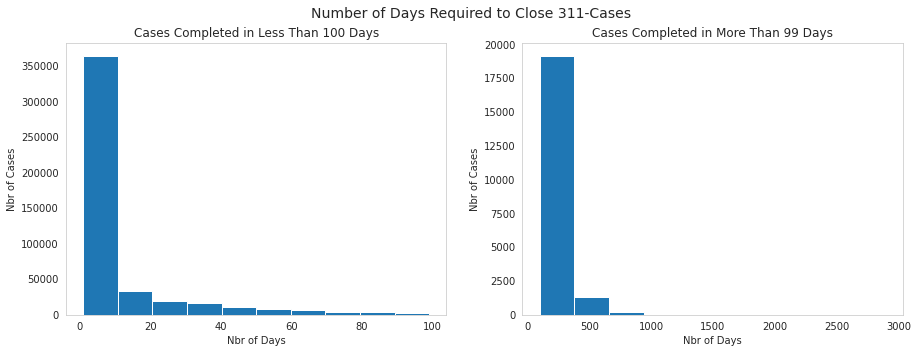

In [ ]:
fig,ax =  plt.subplots(1,2, figsize=(15,5))

fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
ax[0].set(xlabel='Nbr of Days')
ax[1].set(xlabel='Nbr of Days')
ax[0].set(ylabel='Nbr of Cases')
ax[1].set(ylabel='Nbr of Cases')

ax[0].set_title('Cases Completed in Less Than 100 Days')
ax[1].set_title('Cases Completed in Greater Than 99 Days')

ax[0].hist(df_proc_less_100.processing_days)
ax[1].hist(df_proc_more_100.processing_days)
plt.show()

In [ ]:
# break it into 3 blocks...
df_proc_less_50 = df_closed[df_closed['processing_days']<50]
df_proc_less_100 = df_closed[df_closed['processing_days'].between(50,100)]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_50.shape)
print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(444078, 18)
(25780, 18)
(20661, 18)


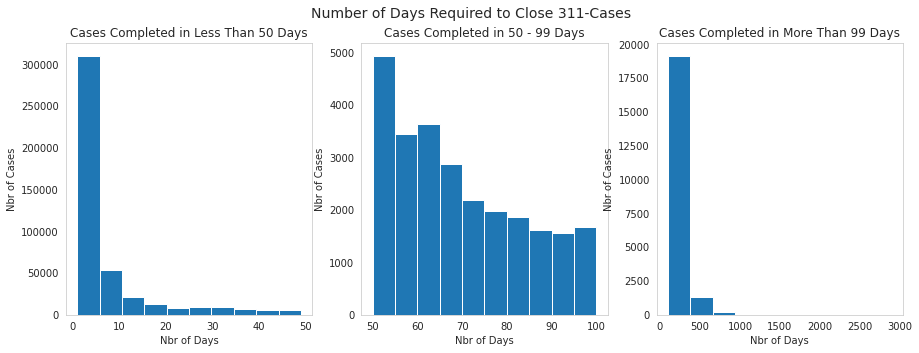

In [ ]:
fig,ax =  plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
for i in range(3):
  ax[i].set(xlabel='Nbr of Days')
  ax[i].set(ylabel='Nbr of Cases')
ax[0].set_title('Cases Completed in Less Than 50 Days')
ax[1].set_title('Cases Completed in 50 - 99 Days')
ax[2].set_title('Cases Completed in More Than 99 Days')

ax[0].hist(df_proc_less_50.processing_days)
ax[1].hist(df_proc_less_100.processing_days)
ax[2].hist(df_proc_more_100.processing_days)
plt.show()

# misleading because compares frequency scales that are completely diffefrent

In [ ]:
del df_proc_less_50, df_proc_less_100, df_proc_more_100

### Plot, over time, nbr of days required to close cases

In [ ]:
print('Processing days range:',df_closed.processing_days.min(),'to',df_closed.processing_days.max())

Processing days range: 1 to 2897


In [ ]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
grouped_df = df_closed.groupby('opened_month_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
grouped_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
grouped_df.head()

,opened_month_year,closing_days_mean,closing_days_min,closing_days_max
0,2008-07,28.515322,1,888
1,2008-08,31.880775,1,869
2,2008-09,23.433085,1,838
3,2008-10,24.685108,1,807
4,2008-11,28.960247,1,774


In [ ]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   opened_month_year  129 non-null    period[M]
 1   closing_days_mean  129 non-null    float64  
 2   closing_days_min   129 non-null    int64    
 3   closing_days_max   129 non-null    int64    
dtypes: float64(1), int64(2), period[M](1)
memory usage: 4.2 KB


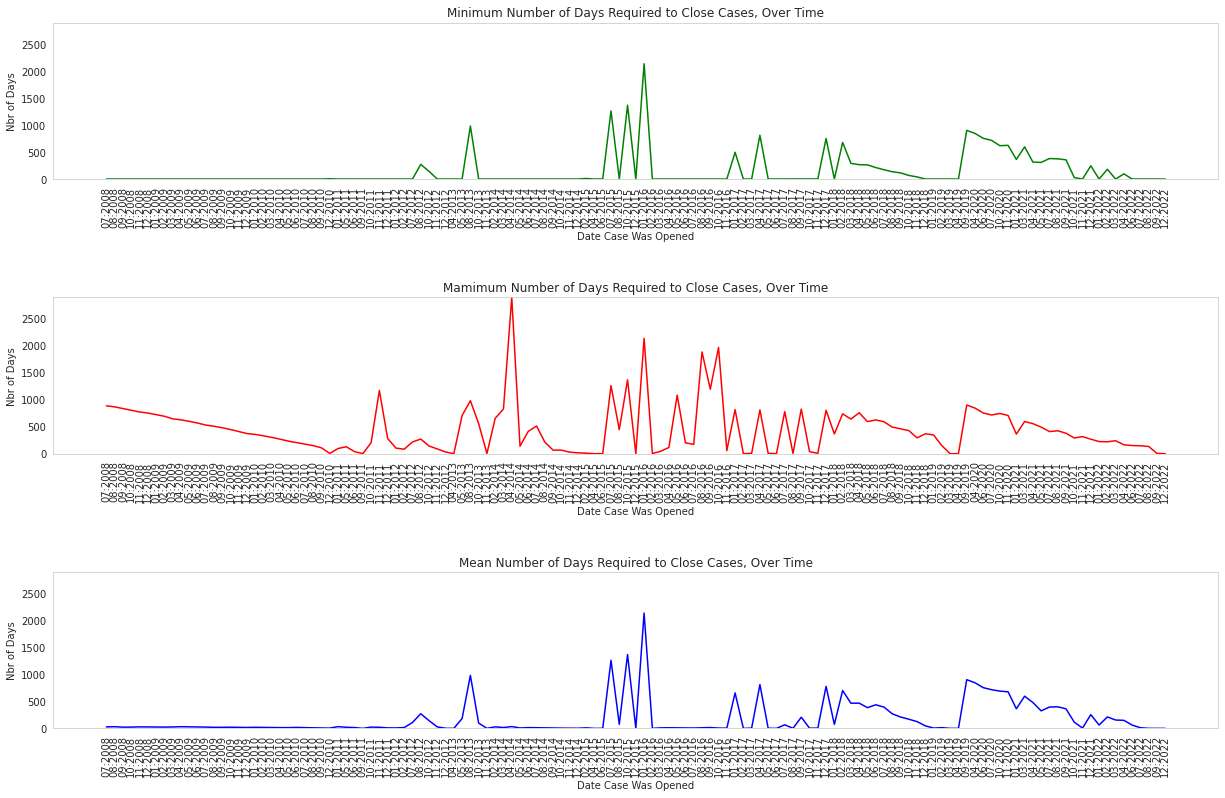

In [ ]:
# Visualize nbr of days it took to close cases, over time

# ISSUE [TODO]
# when more recs were read time frame expaned; now x-axis labels are too close together
# could this be switched to the year, rather than the month?
# to do that, would need to create new col for year opened, then groupby that col

labels = grouped_df.opened_month_year.dt.strftime('%m:%Y').astype(str)
x = grouped_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels, rotation='vertical')
  ax[i].set(xlabel='Date Case Was Opened')
  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)
'''
annotate start of pandemic?
ax.annotate('pixel offset from axes fraction',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
'''
ax[0].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_min, color='g')
ax[1].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_max, color='r')
ax[2].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_mean, color='b')
plt.show()

In [ ]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
year_df = df_closed.groupby('opened_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
year_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
year_df.head()

,opened_year,closing_days_mean,closing_days_min,closing_days_max
0,2008,27.378338,1,888
1,2009,24.154080,1,724
2,2010,15.687908,1,358
3,2011,14.911950,1,1172
4,2012,11.681529,1,272


In [ ]:
del grouped_df

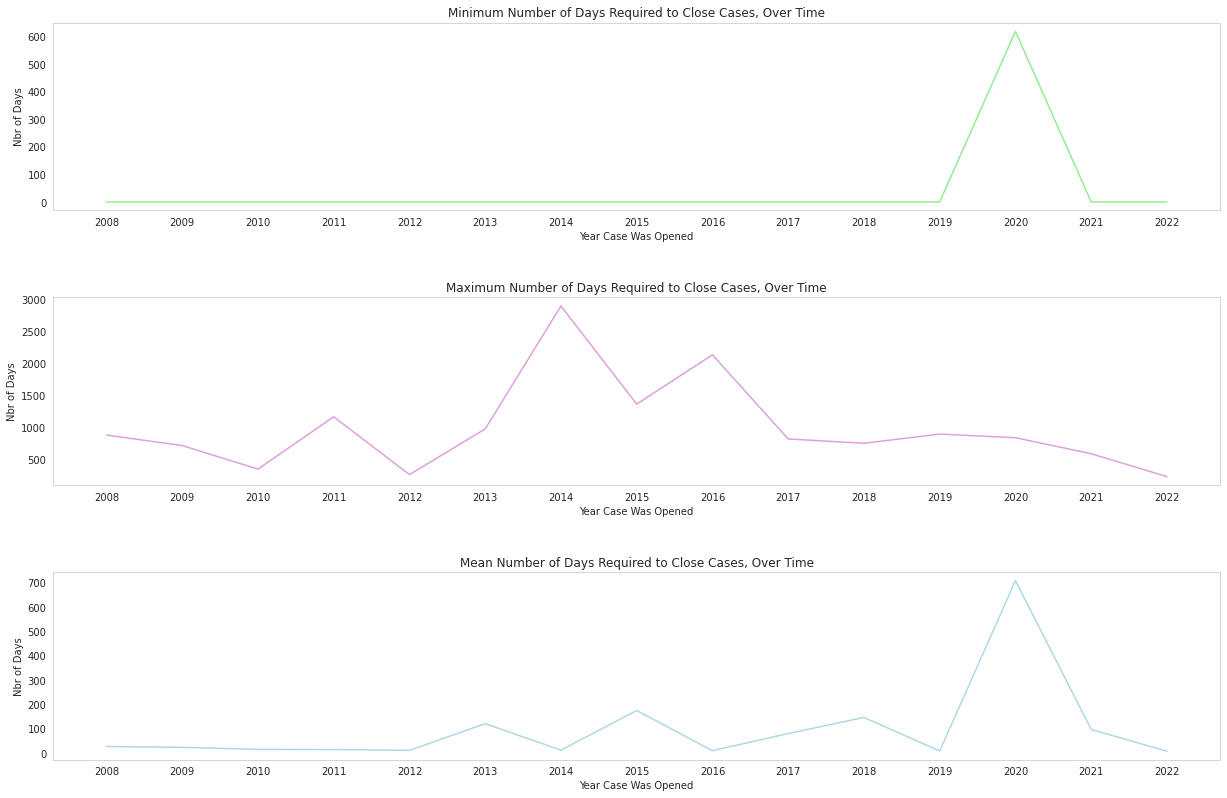

In [ ]:
# same visualization, but at yearly intervals
# NOTE that the y-axis scales are NOT the same

labels = year_df.opened_year.dt.strftime('%Y').astype(str)
x = year_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels)
  ax[i].set(xlabel='Year Case Was Opened')
#  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)

ax[0].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_min, color='lightgreen')
ax[1].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_max, color='plum')
ax[2].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_mean, color='lightblue')
plt.show()

### Changes over time: has the source changed over time?

### Plot closed cases 
  as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict




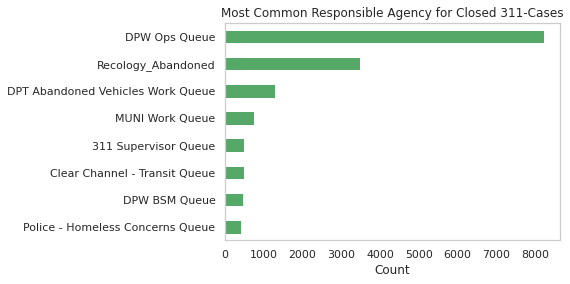

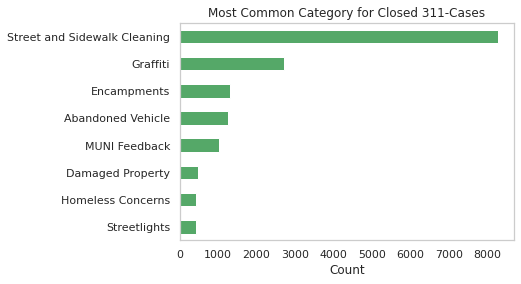

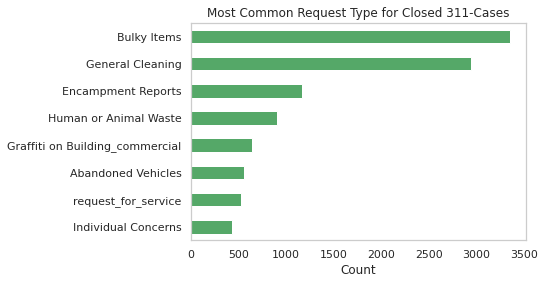

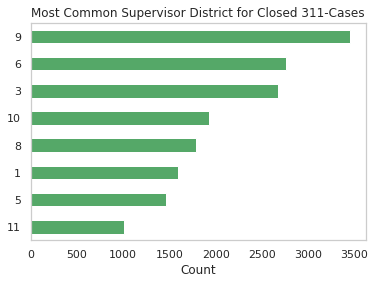

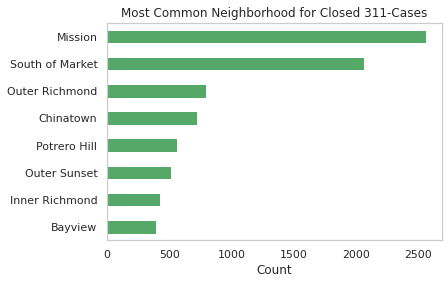

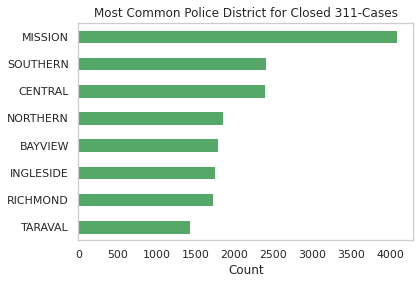

In [ ]:
# plot CLOSED cases (as a Series) by: Responsible Agency, Category, 
#  Request Type, Supervisor District, Neighborhood, Police District
# 'ranking relationship' so using horizontal bar graphs
# for Supervisor District, maybe join to diff table to get supervisor name (based on date)?

elements = ['Responsible Agency','Category', 'Request Type',
            'Supervisor District', 'Neighborhood', 'Police District']

for el in elements:
  plt.title('Most Common '+ el+' for Closed 311-Cases')
  plt.xlabel('Count')
  df_closed[el].value_counts().nlargest(n=8).sort_values().plot(kind='barh',color='g')
  plt.show()


### Plot open cases 
 as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict

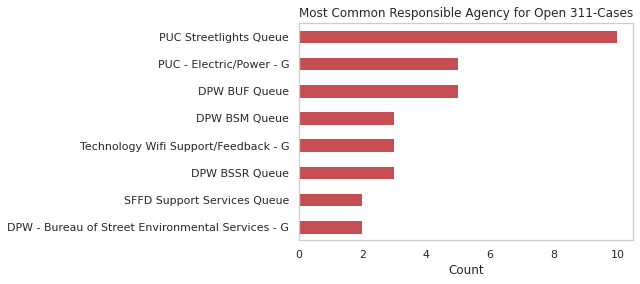

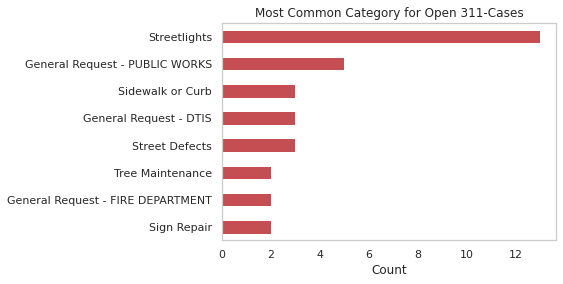

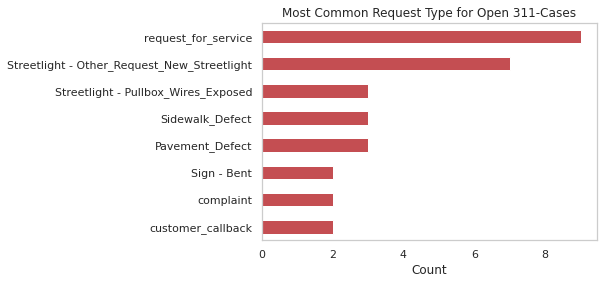

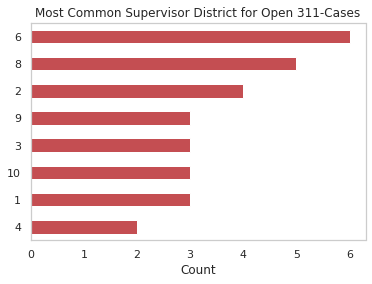

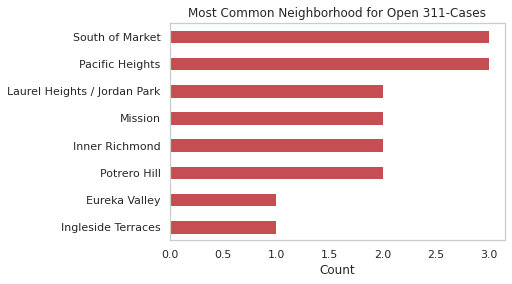

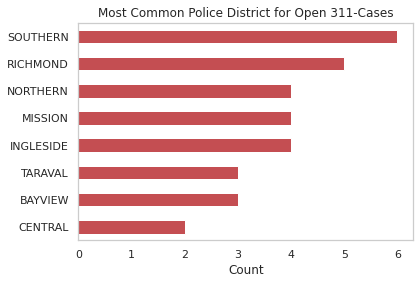

In [ ]:
#  Supervisor District (could join to a diff table to get supervisor name)
# 'ranking relationship' so using horizontal bar graphs

# When considering 'open' cases, focus on cases that have remained open for a lengthy period
# (If a case opened yesterday is still open, that doesn't indicate an issue)

# only consider cases open for at least a year...
df_open_long = df_open[df_open['time_open'].astype('timedelta64[D]') > 365]

for e in elements:
  plt.title('Most Common '+ e+' for Open 311-Cases')
  plt.xlabel('Count')
  df_open_long[e].value_counts().nlargest(n=8).sort_values().plot(kind='barh', color='r')
  plt.show()

## **Question**: Are the most common Closed case types the same as the most common Open case types? Should I be looking at percentages instead? Relative to total number of cases?

## Correlation between [something?] and 'closure rate'
### must define 'closure rate'